In [1]:
import json
import math
import os
from concurrent.futures import ThreadPoolExecutor
from copy import deepcopy
from typing import List, Tuple

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tensorflow import keras
from typing_extensions import TypedDict

In [2]:
IMAGE_SIZE = (512, 512)
TEST_RATIO = 0.2

In [3]:
class GeometricFigure(TypedDict):
    id: int
    category: str
    is_failed: bool
    filename: str
    image: np.ndarray

In [4]:
def load_image(path: str) -> np.ndarray:
    img = Image.open(path)
    img = img.resize(IMAGE_SIZE)
    img = np.array(img, dtype=float)/255
    return img


def get_filenames_from_directory(path: str) -> list:
    return [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]


def process_geometric_figure(geometric_figure: dict):
    return {
        'id': geometric_figure['id'],
        'category': geometric_figure['type'],
        'is_failed': geometric_figure['isFailed'],
        'filename': geometric_figure['filename'],
        'image': load_image(os.path.join('data', 'Geometric Figures', geometric_figure['filename']))
    }


def get_geometric_figures(path: str) -> List[GeometricFigure]:
    with open(path, 'r') as f:
        content = f.read()
    data = json.loads(content)
    with ThreadPoolExecutor() as executor:
        geometric_figures = list(executor.map(process_geometric_figure, data))
    return geometric_figures


geometric_figures: List[GeometricFigure] = get_geometric_figures('data/data.json')
print(f'Loaded {len(geometric_figures)} geometric figures')

Loaded 660 geometric figures


In [5]:
model = keras.models.load_model('data/geometric_figure_classifier.h5')

In [6]:
def predict_to_category(y_pred: np.ndarray) -> str:
    category_mapping = {
        0: 'circle',
        1: 'square',
        2: 'triangle',
    }
    return category_mapping[y_pred.argmax()]

def get_input_and_output(geometric_figure: List[GeometricFigure]) -> Tuple[np.ndarray, np.ndarray]:
    x = geometric_figure['image'][:, :, 1]
    y = {
        'circle': 0,
        'square': 1,
        'triangle': 2,
    }[geometric_figure['category']]
    return x, y

In [7]:
geometric_figures_error_predictions: List[Tuple[GeometricFigure, str]] = []
geometric_figures_array = np.array([gf['image'][:, :, 1] for gf in geometric_figures])
predictions = model.predict(geometric_figures_array)
for i, prediction in enumerate(predictions):
    if predict_to_category(prediction) != geometric_figures[i]['category']:
        geometric_figures_error_predictions.append((geometric_figures[i], predict_to_category(prediction)))
print(f'Predicted {len(geometric_figures_error_predictions)} geometric figures with error')

Predicted 25 geometric figures with error


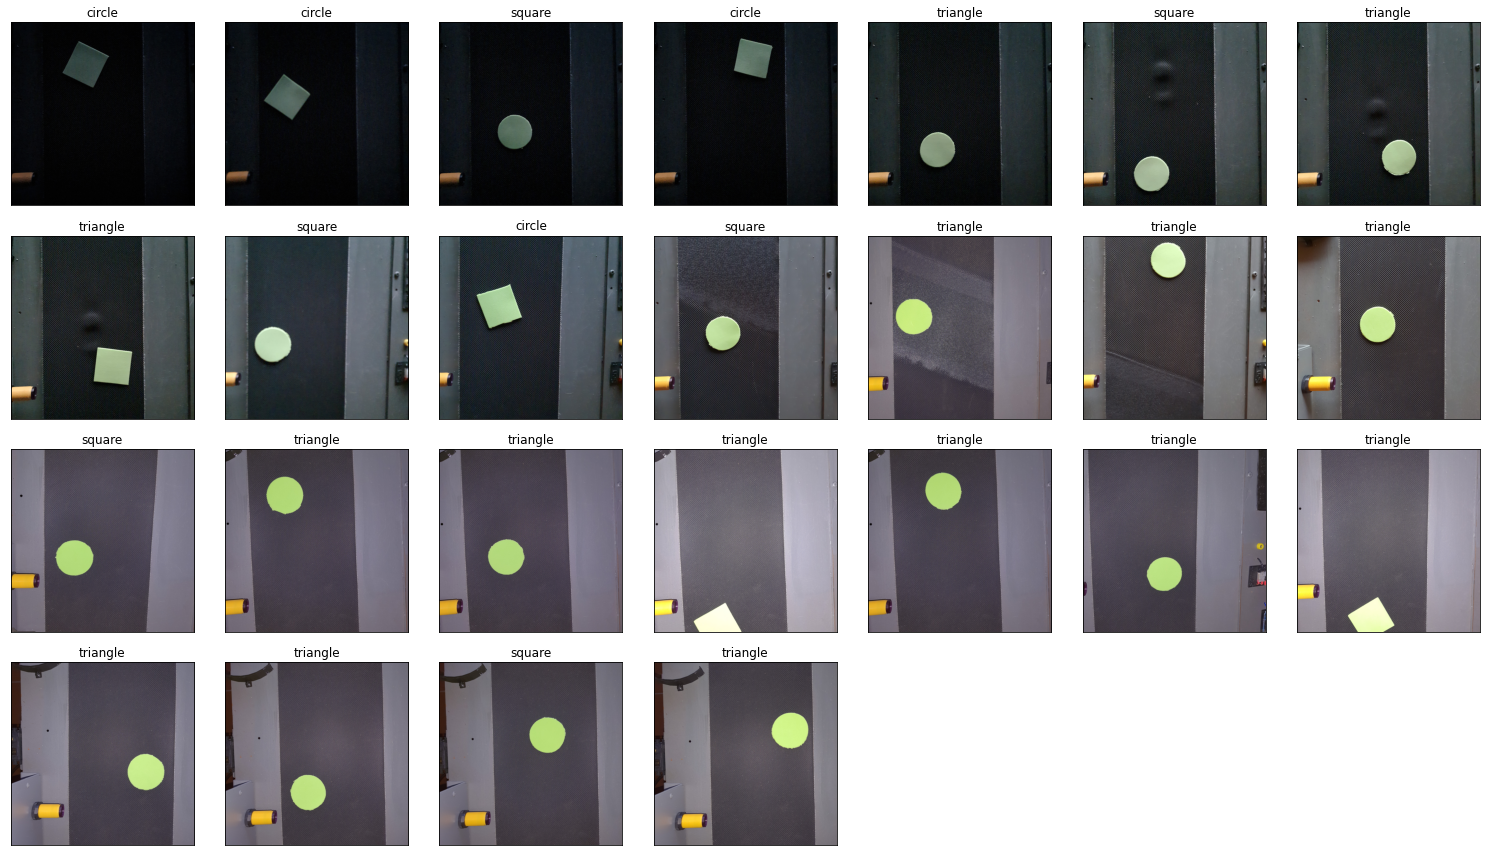

In [8]:
plot_size = 3
columns = 7
rows = math.ceil(len(geometric_figures_error_predictions)/columns)
random_figures = [geometric_figures[np.random.randint(0, len(geometric_figures))] for _ in range(columns * rows)]
fig, axs = plt.subplots(rows, columns, figsize=(columns * plot_size, rows * plot_size))
for i in range(rows):
    for j in range(columns):
        if i * columns + j >= len(geometric_figures_error_predictions):
            axs[i, j].axis('off')
            continue
        geometric_figure, prediction = geometric_figures_error_predictions[i * columns + j]
        x, y = get_input_and_output(geometric_figure)
        x = np.expand_dims(x, axis=0)
        axs[i, j].imshow(geometric_figure['image'])
        axs[i, j].set_title(prediction)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()